# Improving resource assignment in business processes
Given is process data. We are going to answer the following questions:
- How many loan requests are submitted in the future?
- How long needs a case in the future?

## Import required Python libraries
First we need to import some programming libraries which we want to use

In [1]:
import pm4py # Process Mining
from pm4py.objects.log.importer.xes import importer as xes_importer
from sklearn.linear_model import LinearRegression

import matplotlib # Plot
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np # Arrays
import pandas as pd # Data frames and data management

from tabulate import tabulate

## Import event log and discover the process

First we import an event log, stored in the IEEE XES format, from a given file path to the log variable.

In [2]:
# import XES file
# print bpmn process modell

variant = xes_importer.Variants.ITERPARSE
parameters = {variant.value.Parameters.TIMESTAMP_SORT: True}

log = xes_importer.apply('LoanApplication.xes', parameters=parameters)

parsing log, completed traces ::   0%|          | 0/20343 [00:00<?, ?it/s]

### Discover process as direct follows graph

A visualization of the suitable process model according (as a direct follows graph) to the event log imported before.
The process model describes the order of events/activities that are executed during a process execution.

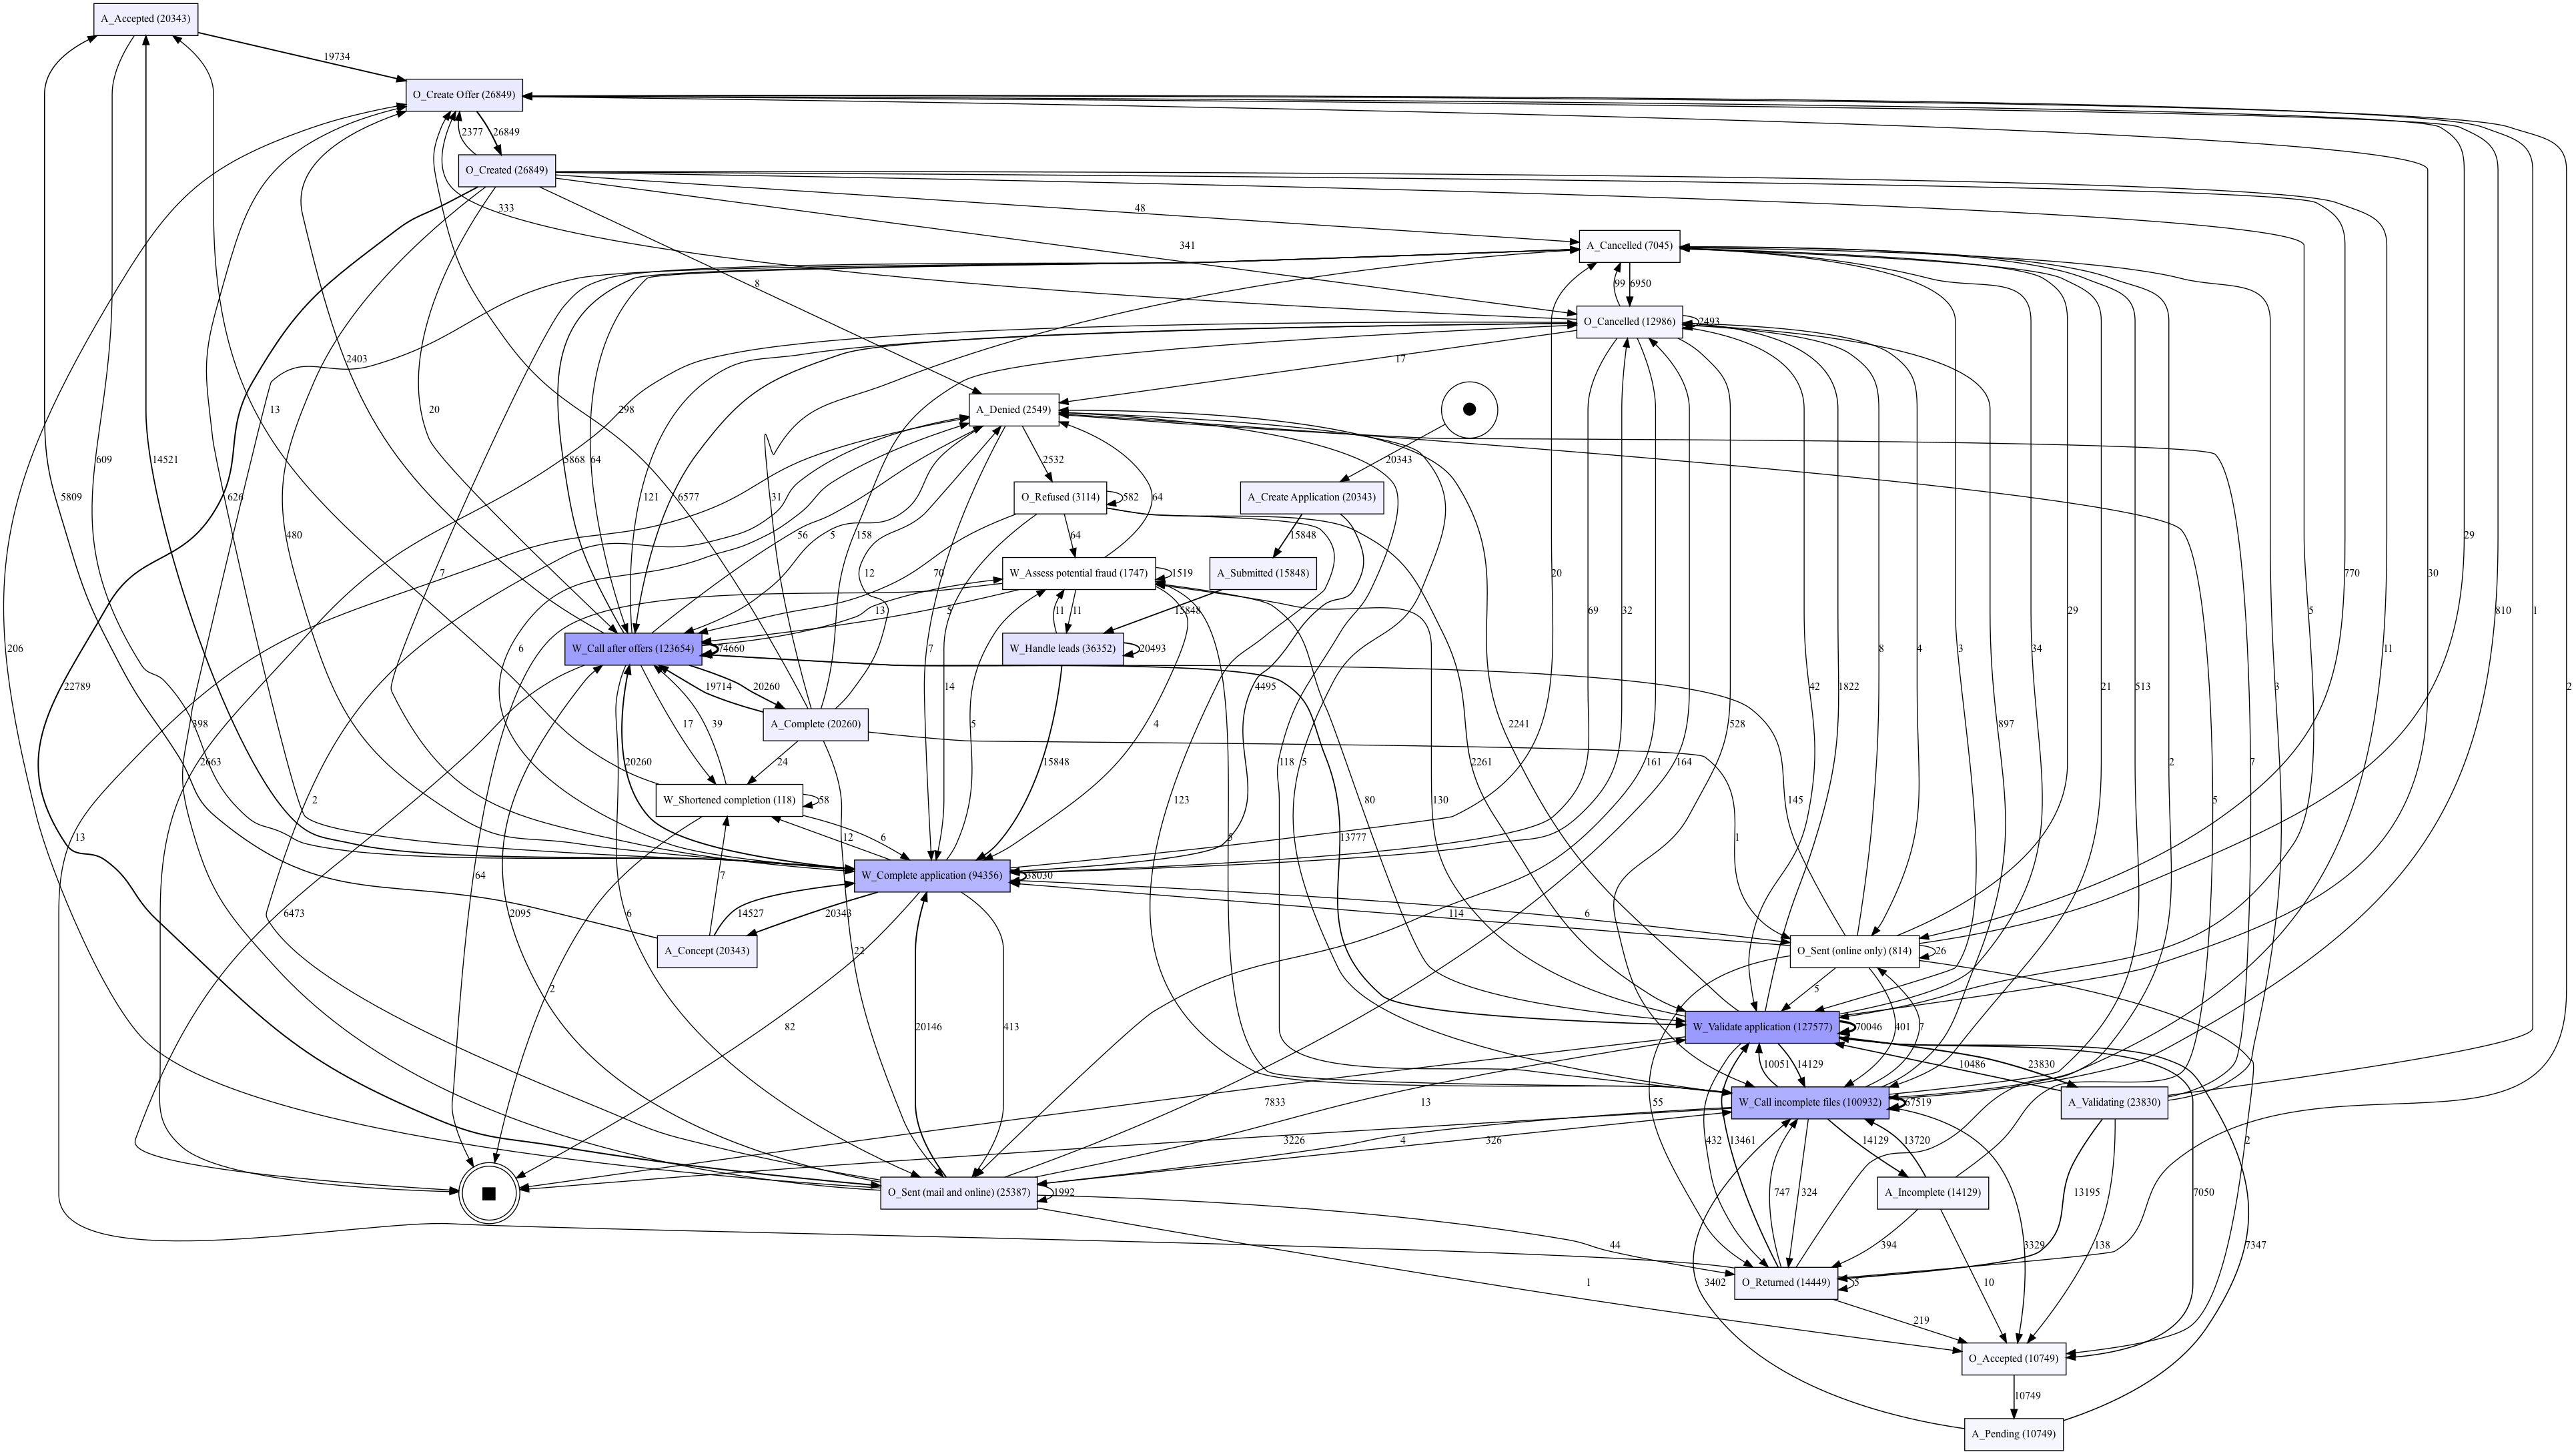

In [3]:
# Create direct follows graph (dfg)
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

### Access and print traces and events of the log

In [4]:
print(log[0]) #prints the first trace of the log
print(log[0][0]) #prints the first event of the first trace

{'attributes': {'LoanGoal': 'Existing loan takeover', 'ApplicationType': 'New credit', 'RequestedAmount': 20000.0, 'concept:name': 'Application_652823628'}, 'events': [{'Action': 'Created', 'org:resource': 'User_1', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 1, 1, 20, 51, 15, 304000, tzinfo=datetime.timezone(datetime.timedelta(seconds=39600))), 'EventID': 'Application_652823628', 'concept:name': 'A_Create Application', 'EventOrigin': 'Application'}, '..', {'Action': 'Deleted', 'org:resource': 'User_115', 'lifecycle:transition': 'ate_abort', 'time:timestamp': datetime.datetime(2016, 1, 15, 2, 49, 11, 423000, tzinfo=datetime.timezone(datetime.timedelta(seconds=39600))), 'EventID': 'Workitem_2067229931', 'concept:name': 'W_Validate application', 'EventOrigin': 'Workflow'}]}
{'Action': 'Created', 'org:resource': 'User_1', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 1, 1, 20, 51, 15, 304000, tzinfo=datetime.timezone(dateti

## Extract features from event log
Given the raw data in the event log, we import the (desriptive and target) features. 
We want to predict future start times, end times, and number of new cases depending on the amount requested.

In [5]:
# create two lists with all start and end times of all traces
# create one list with new trace ids
# create list for requested amount

startTime = []
endTime = []
requestedAmount = []
traceId = []
i=0

for trace in log:
    startTime.append(trace[0]['time:timestamp'])
    endTime.append(trace[len(trace)-1]['time:timestamp'])
    requestedAmount.append(trace.attributes['RequestedAmount'])
    traceId.append(i)
    
    i=i+1

In [6]:
# create training data
# X = [startTime, endTime]
# y = [traceId], i.e., the number of cases that arrived

X = np.array([np.array(startTime),np.array(endTime)]).T
y = np.array(traceId)


#df = pd.DataFrame(X, columns = ['Start','End'])
#print(df)

firsttrainingdata = np.array([np.array(traceId[:10]),np.array(startTime[:10]),np.array(endTime[:10]),np.array(requestedAmount[:10])]).T
print("First 10 elements of training data")
print(tabulate(firsttrainingdata, headers=['Case number','Start Timestamp', 'End Timestamp', 'Requested Amount'],tablefmt='orgtbl'))

First 10 elements of training data
|   Case number | Start Timestamp                  | End Timestamp                    |   Requested Amount |
|---------------+----------------------------------+----------------------------------+--------------------|
|             0 | 2016-01-01 20:51:15.304000+11:00 | 2016-01-15 02:49:11.423000+11:00 |              20000 |
|             1 | 2016-01-01 21:16:11.500000+11:00 | 2016-01-08 00:29:49.725000+11:00 |              10000 |
|             2 | 2016-01-01 22:19:38.177000+11:00 | 2016-01-14 18:00:14.468000+11:00 |              15000 |
|             3 | 2016-01-01 23:34:53.911000+11:00 | 2016-01-28 23:18:51.306000+11:00 |               5000 |
|             4 | 2016-01-02 00:00:04.360000+11:00 | 2016-02-02 18:00:20.849000+11:00 |              35000 |
|             5 | 2016-01-02 00:05:19.866000+11:00 | 2016-02-29 18:00:48.826000+11:00 |              13000 |
|             6 | 2016-01-02 00:22:19.758000+11:00 | 2016-01-10 02:48:53.179000+11:00 |      

### Plot extracted data
Create a 2-dimensional scatter plot relating start and end time with case number. 

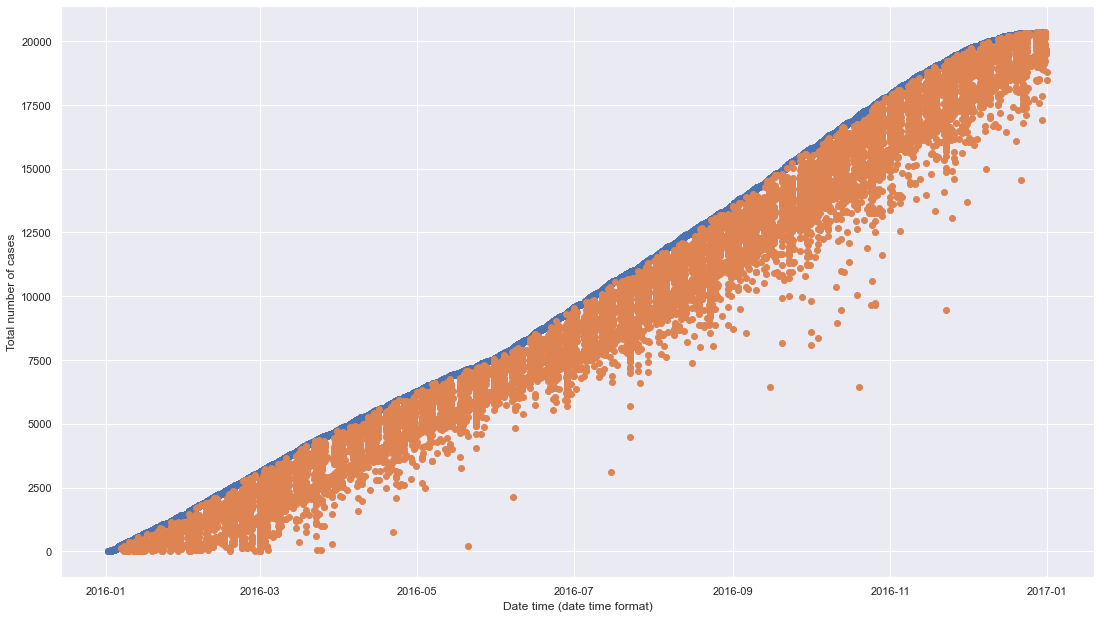

In [7]:
plt.scatter(X[:,0], y)
plt.scatter(X[:,1], y)
plt.xlabel('Date time (date time format)', fontsize=12)
plt.ylabel('Total number of cases', fontsize=12)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

### Convert data to training data for linear regression
Because the linear regression model in Python only processes numbers, we have to convert all dates to numbers.

In [8]:
# convert array with date time to integer
# reference date is 01.01.1970, 00:00:00 000

import time
from datetime import datetime

XInt = np.empty(X.shape)
i=0
for row in X:
    j=0
    for e in row:
        #print(i,",",j)
        #XInt[i,j]=int(e.strftime("%Y%m%d%H%M%S"))
        XInt[i,j]=int(round(e.timestamp() * 1000))
        j=j+1
    i=i+1  



#firsttrainingdata = np.array([XInt[:10],np.array(traceId[:10])]).T
print("First 10 elements of training data, where timestamps were converted to numbers:")
print(tabulate(XInt[:10], headers=['Start Timestamp', 'End Timestamp','Case number'],tablefmt='orgtbl'))

First 10 elements of training data, where timestamps were converted to numbers:
|   Start Timestamp |   End Timestamp |
|-------------------+-----------------|
|       1.45164e+12 |     1.45279e+12 |
|       1.45164e+12 |     1.45217e+12 |
|       1.45165e+12 |     1.45275e+12 |
|       1.45165e+12 |     1.45398e+12 |
|       1.45165e+12 |     1.4544e+12  |
|       1.45165e+12 |     1.45673e+12 |
|       1.45165e+12 |     1.45235e+12 |
|       1.45166e+12 |     1.4525e+12  |
|       1.45166e+12 |     1.45345e+12 |
|       1.45166e+12 |     1.4544e+12  |


### Plot converted training data
Compare it with the scatter plot above: only the format of the x-axis changes from date time to numbers.

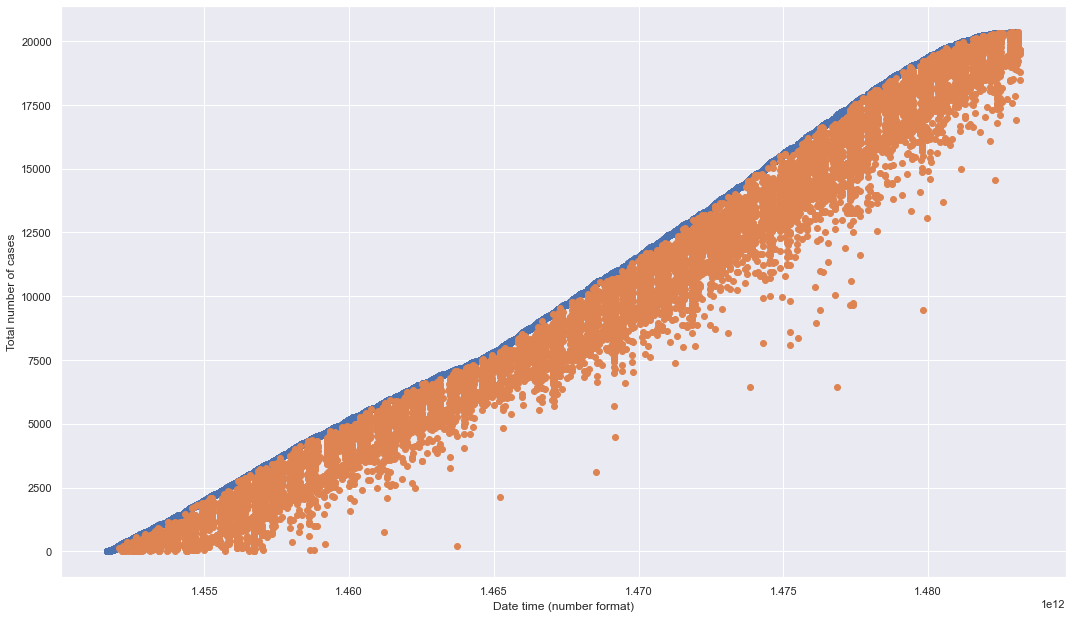

In [9]:
plt.scatter(XInt[:,0], y)
plt.scatter(XInt[:,1], y)

plt.xlabel('Date time (number format)', fontsize=12)
plt.ylabel('Total number of cases', fontsize=12)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 10.5)

### Plot 3-dim training data
Plot the training data where the z-axis shows the case number,
the y-axis shows the converted start time stamp,
and the x-axis shows the requested amount.

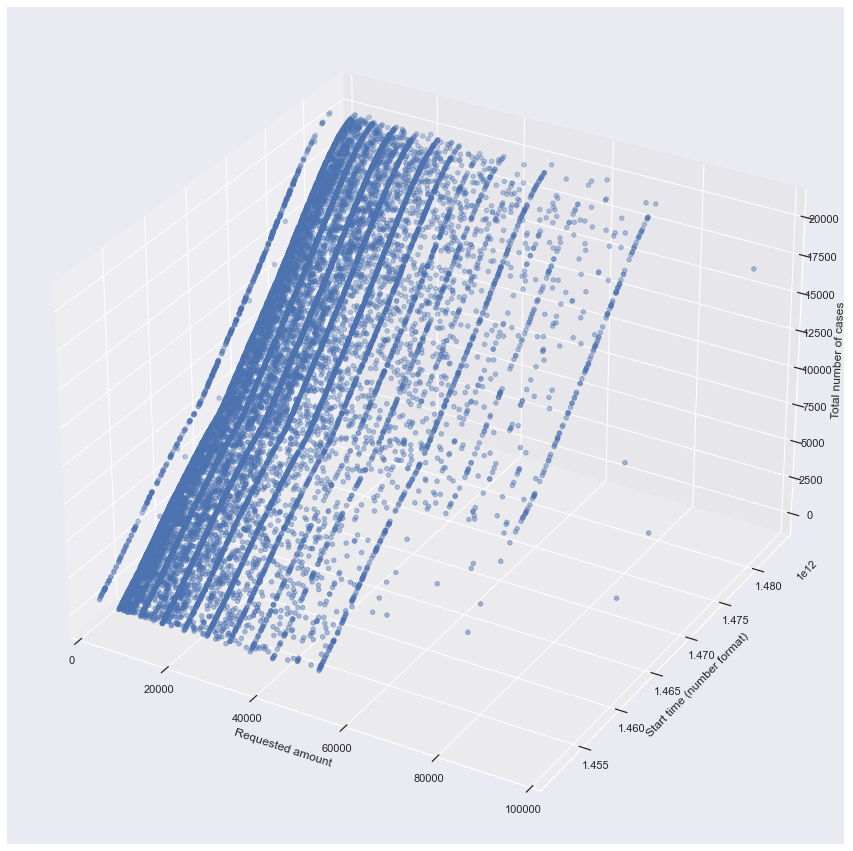

In [10]:
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Requested amount', fontsize=12)
plt.xlim([0, 100000])
ax.set_ylabel('Start time (number format)', fontsize=12)
ax.set_zlabel('Total number of cases', fontsize=12)
ax.scatter(requestedAmount, XInt[:,0], y)
plt.show()

## Build linear regression model
We now want to implement and train our first machine learning model in linear regression style.

### Mapping start and time to case numbers
The first linear function maps the start time to the case number.
The second linear function maps the end time to the case number.

In [11]:
# Build linear regression model
# for StartTime

modelStartTime = LinearRegression(fit_intercept=True)
modelStartTime.fit(XInt[:,0].reshape(-1, 1), y)
print("intercept w[0]: ", modelStartTime.intercept_)
print("coefficient w[1]: ", modelStartTime.coef_)

intercept w[0]:  -1000032.7416411296
coefficient w[1]:  [6.88427794e-07]


In [12]:
# Build linear regression model
# for EndTime

modelEndTime = LinearRegression(fit_intercept=True)
modelEndTime.fit(XInt[:,1].reshape(-1, 1), y)
print("intercept w[0]: ", modelEndTime.intercept_)
print("coefficient w[1]: ", modelEndTime.coef_)

intercept w[0]:  -989565.3793014061
coefficient w[1]:  [6.80412209e-07]


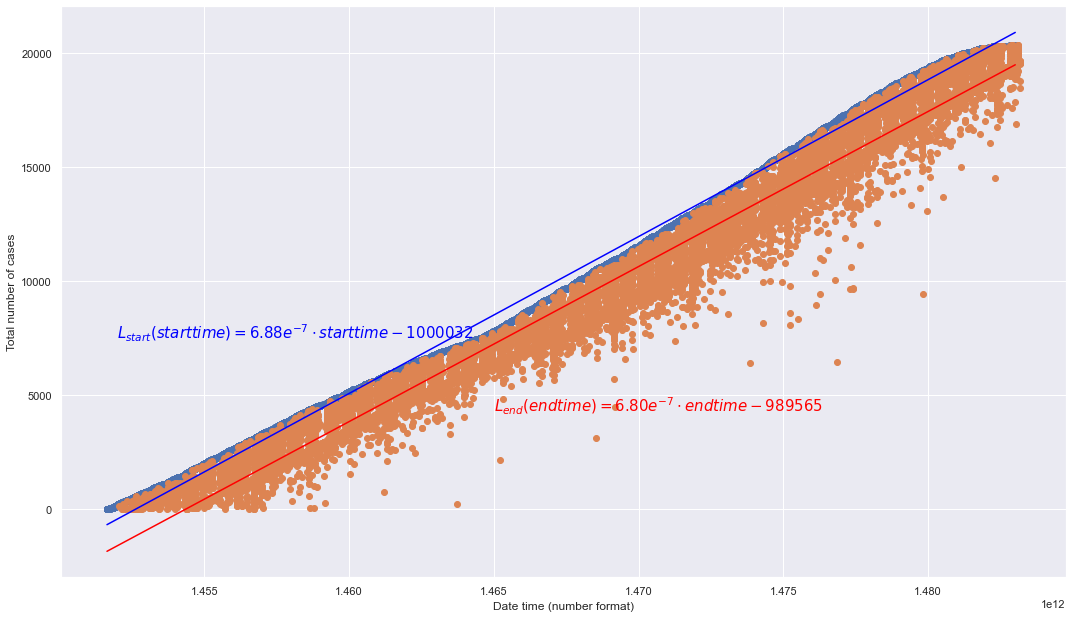

In [13]:
# Plot the result
xfit = np.linspace(XInt[:,0].min(), XInt[:,0].max())
yfit = modelStartTime.predict(xfit[:, np.newaxis])
yfit2 = modelEndTime.predict(xfit[:, np.newaxis])
plt.scatter(XInt[:,0], y)
plt.scatter(XInt[:,1], y)
plt.plot(xfit, yfit,color='blue')
plt.plot(xfit, yfit2, color='red');

plt.xlabel('Date time (number format)', fontsize=12)
plt.ylabel('Total number of cases', fontsize=12)
plt.text(1.452e+12, 7500, r'$L_{start}(starttime)=6.88e^{-7} \cdot starttime - 1000032$', fontsize=15, color='blue')

plt.text(1.465e+12, 4300, r'$L_{end}(endtime)=6.80e^{-7} \cdot endtime - 989565$', fontsize=15, color='red')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 10.5)


### Mapping start time and requested amount to case numbers
The next multiple linear regression function maps the start time and requested amount to the case number. The 

In [14]:
mlr = LinearRegression()  

dataset = pd.DataFrame({'amount': requestedAmount, 'starttime': XInt[:,0]}, columns=['amount', 'starttime'])

mlr.fit(dataset, y)

print("intercept w[0]: ", mlr.intercept_)
print("coefficient w[1]: ", mlr.coef_)

intercept w[0]:  -1000103.9882745368
coefficient w[1]:  [-3.98827102e-04  6.88480809e-07]


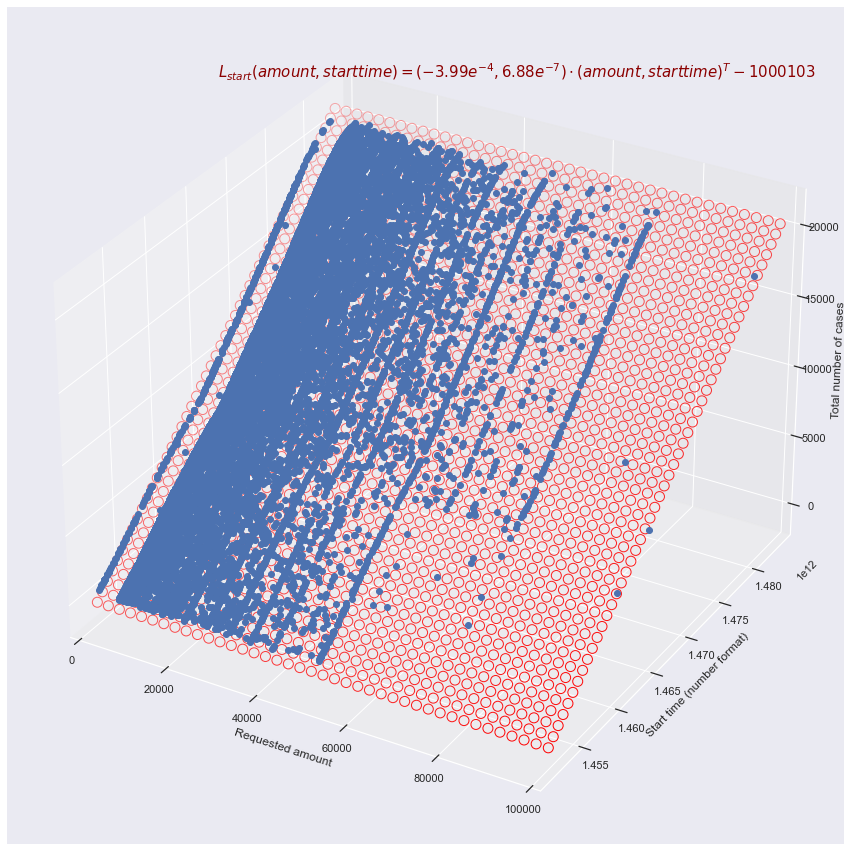

In [15]:
# Plot the result


amount = dataset['amount'] # x
starttime = dataset['starttime'] # y
z = y # z

x_pred = np.linspace(dataset['amount'].min(),100000,num=40)      # range of amount
y_pred = np.linspace(dataset['starttime'].min(),dataset['starttime'].max())  # range of start time
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

predicted = mlr.predict(model_viz)


fig = plt.figure(figsize=(15, 20))

ax = fig.add_subplot(projection='3d')

ax.plot(amount, starttime, z, zorder=15, linestyle='none', marker='o')
ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=100, edgecolor='red')


plt.xlim([0, 100000])

ax.set_xlabel('Requested amount', fontsize=12)
ax.set_ylabel('Start time (number format)', fontsize=12)
ax.set_zlabel('Total number of cases', fontsize=12)

ax.text(x=40000, y=1.447e+12, z=40000, s=r'$L_{start}(amount,starttime)=(-3.99e^{-4}, 6.88e^{-7}) \cdot (amount,starttime)^T - 1000103$', fontsize=15, color='darkred')

plt.show()

## Make predictions

Based on the linear regression models we can make prediction, for example:
- Total number of cases started in the future
- Duration of cases in the future

### Number of cases started in the future
The function `numberOfCases` requires as input a date in the future (e.g. 2018-01-01) and the linear regression model mapping the start time of cases to case number. The function returns the number of cases started befor that date.

In [16]:
def numberOfCases(date,model = modelStartTime):
    x = np.array(int(round(date.timestamp() * 1000)))
    totalCasesStarted = modelStartTime.predict(x.reshape(-1, 1))
    print("In total " + str(totalCasesStarted) + " cases were started befor " + str(date) + ".")
    return totalCasesStarted

In [17]:
from datetime import datetime
 
inputstring = str(input('Enter date (yyyy-mm-dd): '))
date = datetime.strptime(inputstring, "%Y-%m-%d")

totalCasesStarted = int(numberOfCases(date))
print(totalCasesStarted - len(y), "new cases started since the last case in event log started.")

Enter date (yyyy-mm-dd): 2017-12-31
In total [42711.48997107] cases were started befor 2017-12-31 00:00:00.
22368 new cases started since the last case in event log started.


### Duration of cases in the future
The function `caseDuration` requires as input a date in the future (e.g. 2018-01-01) and the two linear regression models mapping the start time and end time of cases to the case number. The function returns the duration of cases started on that date.

In [18]:
def caseDuration(date,modelStart = modelStartTime, modelEnd = modelEndTime):
    x = np.array(int(round(date.timestamp() * 1000)))
    totalCasesStarted = modelStartTime.predict(x.reshape(-1, 1))
    
    endTime = (totalCasesStarted - modelEndTime.intercept_) / modelEndTime.coef_
    
    endTime = datetime.datetime.fromtimestamp(int(endTime / 1000))
    #startTime = datetime.fromtimestamp(int(date / 1000))
    caseduration = endTime - date
    
    print("A new case starting on "+ str(date) + " needs " + str(caseduration) + ".")
    return caseduration

In [20]:
import datetime
 
inputstring = str(input('Enter date (yyyy-mm-dd): '))
date = datetime.datetime.strptime(inputstring, "%Y-%m-%d")

caseduration = (caseDuration(date))

Enter date (yyyy-mm-dd): 2016-12-31
A new case starting on 2016-12-31 00:00:00 needs 24 days, 4:03:59.
